# Tentando entender o que afeta os coeficientes da regress√£o log√≠stica

Ver o impacto de um fator multiplicativo em uma vari√°vel de entrada e de ru√≠do

#### Meu pensamento inicial:
> - fator multiplicativo afeta coeficientes (ex.: conver√ß√£o de moeda: R$->US$)
> - ru√≠do n√£o afeta os coeficientes*

*assumindo que a m√©dia do ru√≠do √© zero e for√ßando que o ru√≠do n√£o desnormalize os dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
sns.set()

In [2]:
# Fun√ß√£o para aplicar o ru√≠do
def aplly_noise(noise_intensity=1):
  def func(input):
    noise_amplitude = noise_intensity*math.sin(input*math.pi)/4
    noise = np.random.uniform(-noise_amplitude,noise_amplitude)
    return input+noise
  return func

In [3]:
# "intensidade" dos ru√≠dos
noise_levels = {
  'noised_a': 0.33333,
  'noised_b': 0.66667,
  'noised_c': 1,
}

# dataframe com entrada pura, com diferentes n√≠veis de ru√≠do, entrada aleat√≥ria e sa√≠da esperada
df = pd.DataFrame()
df['inputs'] = np.linspace(0,1,10000)
df['noised_a'] = df['inputs'].map(aplly_noise(noise_levels['noised_a']))
df['noised_b'] = df['inputs'].map(aplly_noise(noise_levels['noised_b']))
df['noised_c'] = df['inputs'].map(aplly_noise(noise_levels['noised_c']))
df['random'] = np.random.uniform(0,1, len(df['inputs']))
df['outputs'] = df['inputs'].map(lambda input: 0 if input<0.5 else 1)

# primeiras e ultimas linhas para ilustrar
df.take([0,1,-2,-1])

inputs  noised_a  noised_b  noised_c    random  outputs
0     0.0000  0.000000  0.000000  0.000000  0.347951        0
1     0.0001  0.000098  0.000089  0.000130  0.729484        0
9998  0.9999  0.999912  0.999872  0.999904  0.203812        1
9999  1.0000  1.000000  1.000000  1.000000  0.986821        1

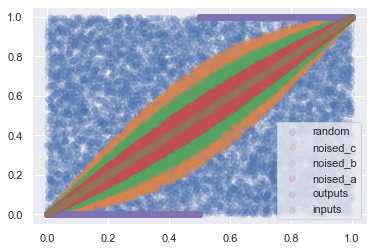

In [4]:
# Dispers√£o de todas as colunas do dataframe

fig, ax = plt.subplots()
ax.scatter(x=df.inputs, y=df.random, label="random", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_c, label="noised_c", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_b, label="noised_b", alpha=.15)
ax.scatter(x=df.inputs, y=df.noised_a, label="noised_a", alpha=.15)
ax.scatter(x=df.inputs, y=df.outputs, label="outputs", alpha=.15)
ax.scatter(x=df.inputs, y=df.inputs, label="inputs", alpha=.15)
ax.legend()

# ü§î Pra que tudo isso?
- `inputs`: entrada ideal para determinar os `outputs`
- `noised_X`: varia√ß√µes do `inputs` com algum ru√≠do. Ru√≠do se intensifica apenas no centro para evitar a "desnormaliza√ß√£o" dos dados (mesmo com o ru√≠do, tudo fica entre 0 e 1)
- `inputs`: entrada aleat√≥ria que n√£o deve apresentar correla√ß√£o com `outputs`

### Regrass√£o com `inputs`:

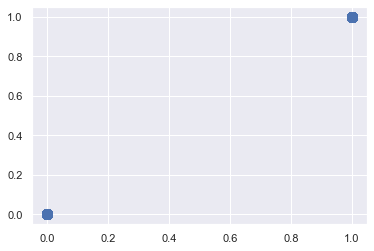

In [5]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, s=100)

> regress√£o perfeita, nenhum falso positivo ou falso negativo

### Regrass√£o com `noised_a`:

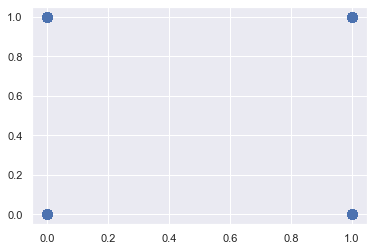

In [6]:
X = df[['noised_a']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

noised_a_coefs = (clf.coef_[0][0], clf.intercept_[0])
plt.scatter(x=y, y=y_pred, alpha=0.01, s=100)

> regress√£o imperfeita, alguns falsos positivos e falsos negativos

# Comparando os coeficientes isolados

In [7]:
print('input_coefs:',input_coefs)
print('noised_a_coefs:',noised_a_coefs)

input_coefs: (25.430619174690186, -12.71529402057659)
noised_a_coefs: (21.70734813495863, -10.853287081588034)


### Conclus√£o1: Meu pensamento inicial estava errado.
O ruido afetou o coeficiente

# Vendo os coeficientes usando todas as vari√°veis

In [8]:
X = df[['inputs','noised_a','noised_b','noised_c','random']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

inputs  noised_a  noised_b  noised_c    random
0  16.526663  9.558946  5.117222  2.454596  0.043821

# Vendo o efeito do fator multiplicativo em uma das entradas

In [9]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals/10)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

inputs  noised_a  noised_b  noised_c    random
0  20.740161  2.014887  5.795892  2.872871  0.023844

In [10]:
X = df[['inputs','noised_a','noised_b','noised_c','random']].copy()
X['noised_a'] = X['noised_a'].map(lambda vals: vals*10)
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

pd.DataFrame(clf.coef_, columns=X.columns)

inputs  noised_a  noised_b  noised_c    random
0  12.944436  2.231919  4.767061  2.205989  0.063993

# Vendo o efeito do fator multiplicativo em uma das entradas em casos isolados

In [30]:
X = df[['inputs']]
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs = (clf.coef_[0][0], clf.intercept_[0])

In [41]:
X = df[['inputs']].copy()
X.inputs = X.inputs*1000
y = df['outputs']

clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)
y_proba = clf.predict_proba(X)

input_coefs_1000 = (clf.coef_[0][0], clf.intercept_[0])

#### Comparando os coeficientes

In [42]:
print("Com entrada original:",input_coefs)
print("Entrada multiplicada:",input_coefs_1000)

Com entrada original: (25.430619174690186, -12.71529402057659)
Entrada multiplicada: (2.544529425667609, -1272.2647617800062)
